In [1]:
# Started 2022-2-20
# First try at making an GRE EPI sequence for the inside scanner, based on the demo write_epi.py script

import math
import numpy as np
import pypulseq as pp

# Custom functions
import viz # visualization

In [2]:
# ======
# SETUP
# ======
seq = pp.Sequence()  # Create a new sequence object
# Define FOV and resolution
fov = 160e-3
Nx = 16
Ny = Nx
slice_thickness = 3e-3  # Slice thickness
n_slices = 1

# Set system limits
system = pp.Opts(max_grad=100, grad_unit='mT/m',
                 max_slew=200, slew_unit='T/m/s',
                 grad_raster_time=10e-6)

# ======
# CREATE EVENTS
# ======
# Create 90 degree slice selection pulse and gradient
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=np.pi / 2,
    system=system,
    duration=3e-3,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    return_gz=True,
)

# Define other gradients and ADC events
delta_k = 1 / fov
k_width = Nx * delta_k
dwell_time = 4e-6
readout_time = Nx * dwell_time
flat_time = np.ceil(readout_time * 1e5) * 1e-5  # round-up to the gradient raster
gx = pp.make_trapezoid(
    channel="x",
    system=system,
    amplitude=k_width / readout_time,
    flat_time=flat_time,
)
adc = pp.make_adc(
    num_samples=Nx,
    duration=readout_time,
    delay=gx.rise_time + flat_time / 2 - (readout_time - dwell_time) / 2,
)

# Pre-phasing gradients
pre_time = 8e-4
gx_pre = pp.make_trapezoid(
    channel="x", system=system, area=-gx.area / 2, duration=pre_time
)
gz_reph = pp.make_trapezoid(
    channel="z", system=system, area=-gz.area / 2, duration=pre_time
)
gy_pre = pp.make_trapezoid(
    channel="y", system=system, area=-Ny / 2 * delta_k, duration=pre_time
)

# Phase blip in the shortest possible time
dur = np.ceil(2 * np.sqrt(delta_k / system.max_slew) / 10e-6) * 10e-6
gy = pp.make_trapezoid(channel="y", system=system, area=delta_k, duration=dur)

# ======
# CONSTRUCT SEQUENCE
# ======
# Define sequence blocks
for s in range(n_slices):
    rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
    seq.add_block(rf, gz)
    seq.add_block(gx_pre, gy_pre, gz_reph)
    for i in range(Ny):
        seq.add_block(gx, adc)  # Read one line of k-space
        seq.add_block(gy)  # Phase blip
        gx.amplitude = -gx.amplitude  # Reverse polarity of read gradient

ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed! Error listing follows:")
    print(error_report)

Timing check passed successfully


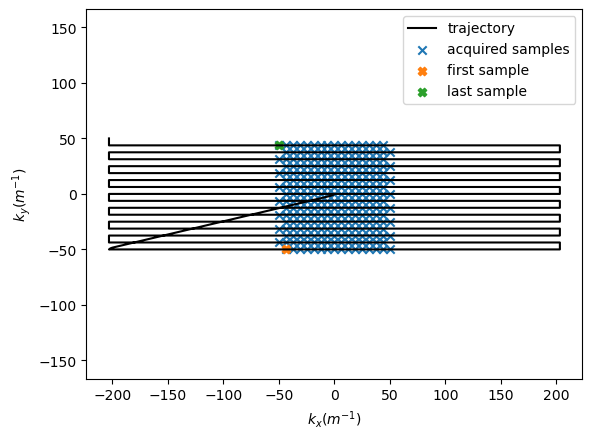

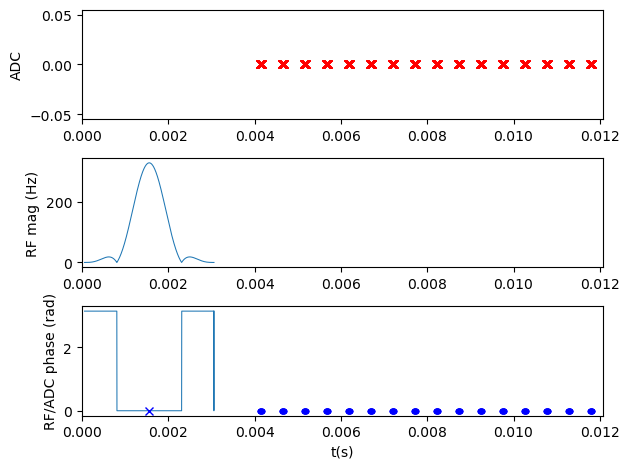

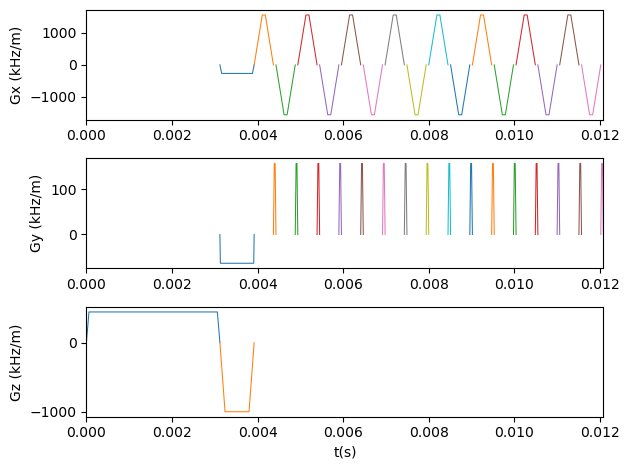

Number of blocks: 34
Number of events:
RF:      1
Gx:     17
Gy:     17
Gz:      2
ADC:     16
Delay:      0
Sequence duration: 0.012080 s
TE: 0.006665 s
TR: 0.012080 s
Flip angle: 90.00 deg
Unique k-space positions (aka cols, rows, etc.): 17 16 
Dimensions: 2
Spatial resolution: 10.00 mm
Spatial resolution: 10.00 mm
Repetitions/slices/contrasts: 1.0
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Event timing check passed successfully
Max gradient: 1562500 156250 1000000 Hz/m == 36.70 3.67 23.49 mT/m
Max slew rate: 8223684211 7812500000 8333333333 Hz/m/s == 193.15 183.50 195.73 mT/m/s
Max absolute gradient: 1562500 Hz/m == 36.70 mT/m
Max absolute slew rate: 1.11402e+10 Hz/m/s == 261.65 T/m/s


In [3]:
# ======
# VISUALIZATION
# ======

# Calculate and visualize k-space
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()
viz.plot2Dkspace(k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc)


plot = True
if plot:
    seq.plot()

# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within slew-rate limits
rep = seq.test_report()
print(rep)

In [4]:
# =========
# WRITE .SEQ
# =========
write_seq = False
if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition(key="FOV", val=[fov, fov, slice_thickness])
    seq.set_definition(key="Name", val="EPI")

    seq.write("rex_2_epi.seq")